# Data Analysis using Pandas

In [2]:
%matplotlib inline 

# This is a magic line function in python.
# The output of plotting commands is displayed inline within frontends like the Jupyter notebook,
# directly below the code cell that produced it.

#Imprting required packages in python

import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

#Below function in Pandas sets maximum number of rows to be displayed from the data fetched      
pd.options.display.max_rows = 10

# Seaborn comes with a number of customized themes and a high-level interface for controlling the look of matplotlib figures.
#ticks is one of the five preset seaborn themes.
#The four preset contexts, in order of relative size, are paper, notebook, talk, and poster. 
#It accordingly formats the output plotting

sns.set(style='ticks', context='talk')

In [3]:
#pd.read_html reads tabular data from an HTML page and stores it as  a dataframe
tables = pd.read_html("http://www.basketball-reference.com/leagues/NBA_2016_games.html")

# Since tables is a huge dataset, we take only first few rows for analysis. head() function does the task.
#tables[0] is first few elements of table list and head() is further a subset of that data.
games = tables[0]
games.head()


,Date,Start (ET),Visitor/Neutral,PTS,Home/Neutral,PTS.1,,.1,Notes
0,"Tue, Oct 27, 2015",8:00 pm,Detroit Pistons,106,Atlanta Hawks,94,Box Score,NaN,NaN
1,"Tue, Oct 27, 2015",8:00 pm,Cleveland Cavaliers,95,Chicago Bulls,97,Box Score,NaN,NaN
2,"Tue, Oct 27, 2015",10:30 pm,New Orleans Pelicans,95,Golden State Warriors,111,Box Score,NaN,NaN
3,"Wed, Oct 28, 2015",7:30 pm,Philadelphia 76ers,95,Boston Celtics,112,Box Score,NaN,NaN
4,"Wed, Oct 28, 2015",7:30 pm,Chicago Bulls,115,Brooklyn Nets,100,Box Score,NaN,NaN


In [4]:
# The column names like start(ET), PTS , home/neutral are not very useful, hence we rename them as below
# columns renmaed to user defined column_names as below

column_names = {'Date': 'date', 'Start (ET)': 'start',
                'Unamed: 2': 'box', 'Visitor/Neutral': 'away_team', 
                'PTS': 'away_points', 'Home/Neutral': 'home_team',
                'PTS.1': 'home_points', 'Unamed: 7': 'n_ot'}

games = (games.rename(columns=column_names)
         .dropna(thresh=4) # Delete the column if more than 4 row values are NA or NaN 
         [['date', 'away_team', 'away_points', 'home_team', 'home_points']] # Take only these columns from games table
         .assign(date=lambda x: pd.to_datetime(x['date'], format='%a, %b %d, %Y')) # This function converts string to date and changes the format
         .set_index('date', append=True) #Set the DataFrame index (row labels) using one or more existing columns.
         .rename_axis(["game_id", "date"]) #rename the first two columns
         .sort_index()) # sort by label along the axis or values in the column
games.head()

,,away_team,away_points,home_team,home_points
game_id,date,,,,
0,2015-10-27,Detroit Pistons,106,Atlanta Hawks,94
1,2015-10-27,Cleveland Cavaliers,95,Chicago Bulls,97
2,2015-10-27,New Orleans Pelicans,95,Golden State Warriors,111
3,2015-10-28,Philadelphia 76ers,95,Boston Celtics,112
4,2015-10-28,Chicago Bulls,115,Brooklyn Nets,100


In [5]:
tidy = pd.melt(games.reset_index(), #melt function is used to combine two columns to one, preserving the metadata.
                           #reset_index reset the multilevel index and returns new data frame with new index
               id_vars=['game_id', 'date'], value_vars=['away_team', 'home_team'], #preserve game_id and date and combine away_team and home_team  
               value_name='team') # name that new column as team

tidy.head() #take first few rows of this newly filtered data set
#tidy reutrns 76 rows and 4 column dataset instead.

,game_id,date,variable,team
0,0,2015-10-27,away_team,Detroit Pistons
1,1,2015-10-27,away_team,Cleveland Cavaliers
2,2,2015-10-27,away_team,New Orleans Pelicans
3,3,2015-10-28,away_team,Philadelphia 76ers
4,4,2015-10-28,away_team,Chicago Bulls


In [6]:
tidy.groupby('team')['date'].diff().dt.days - 1
#gets the number of days between 2 games for each team.

0     NaN
1     NaN
2     NaN
3     NaN
4     NaN
     ... 
71    1.0
72    2.0
73    2.0
74    2.0
75    0.0
Name: date, Length: 76, dtype: float64

In [7]:
tidy['rest'] = tidy.sort_values('date').groupby('team').date.diff().dt.days - 1
tidy.dropna().head()
#Add the rest data to the table as a new column at the end of the table, sort by date, group by team

,game_id,date,variable,team,rest
4,4,2015-10-28,away_team,Chicago Bulls,0.0
8,8,2015-10-28,away_team,Cleveland Cavaliers,0.0
14,14,2015-10-28,away_team,New Orleans Pelicans,0.0
17,17,2015-10-29,away_team,Memphis Grizzlies,0.0
18,18,2015-10-29,away_team,Dallas Mavericks,0.0


In [8]:
# Now we assign the rest column to the main data frame tables
# We also revert the melt function changes using the pivot_table method and store in by_game
# hence we have away team and home team. we thus have 2 rest values away rest and home rest and map them correspondingly

by_game = (pd.pivot_table(tidy, values='rest',
                          index=['game_id', 'date'], #set these as the index
                          columns='variable')
             .rename(columns={'away_team': 'away_rest', # we rename columns as 2 new rows are added. 
                              'home_team': 'home_rest'})) # team and rest split to away and home
df = pd.concat([games, by_game], axis=1) # we concat 2 tables game and by_game 
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest
game_id,date,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0


In [9]:
# Seaborn comes with a number of customized themes and a high-level interface for controlling the look of matplotlib figures.
#ticks is one of the five preset seaborn themes.
#The four preset contexts, in order of relative size, are paper, notebook, talk, and poster. 
#It accordingly formats the output plotting

sns.set(style='ticks', context='paper')

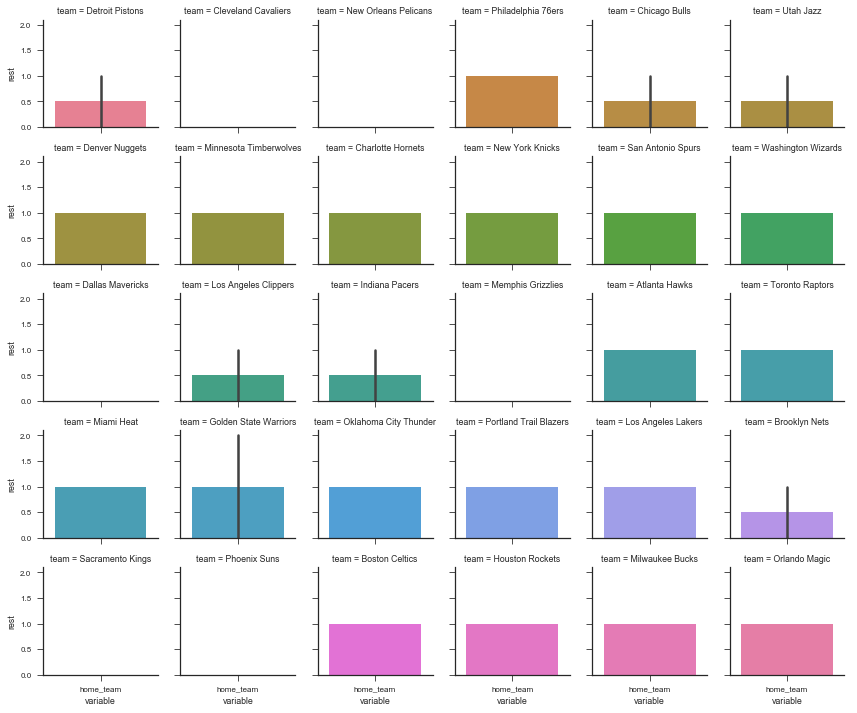

In [10]:
# The FacetGrid is an object that links a Pandas DataFrame to a matplotlib figure with a particular structure.
# In particular, FacetGrid is used to draw plots with multiple Axes where each Axes shows the same relationship conditioned 
# on different levels of some variable. It’s possible to condition on up to three variables by assigning variables to 
# the rows and columns of the grid and using different colors for the plot elements.
# Map function is a part of facetgrid function. 
# FacetGrid takes the dataframe and formatting arguements whileMap is used to plot the data.

g = sns.FacetGrid(tidy, col='team', col_wrap=6, hue='team', size=2)
g.map(sns.barplot, 'variable', 'rest');

In [11]:
# Now lets look into some statistics.
# We take a parameter home_win which returns a boolean value. 
# It returns true if home_points are greater than away points else returns false
# Rest spread is the difference between rest at home and rest away from home

df['home_win'] = df['home_points'] > df['away_points']
df['rest_spread'] = df['home_rest'] - df['away_rest']
df.dropna().head()

,,away_team,away_points,home_team,home_points,away_rest,home_rest,home_win,rest_spread
game_id,date,,,,,,,,
17,2015-10-29,Memphis Grizzlies,112,Indiana Pacers,103,0.0,0.0,False,0.0
18,2015-10-29,Dallas Mavericks,88,Los Angeles Clippers,104,0.0,0.0,True,0.0
19,2015-10-29,Atlanta Hawks,112,New York Knicks,101,1.0,0.0,False,-1.0
20,2015-10-30,Charlotte Hornets,94,Atlanta Hawks,97,1.0,0.0,True,-1.0
21,2015-10-30,Toronto Raptors,113,Boston Celtics,103,1.0,1.0,False,0.0


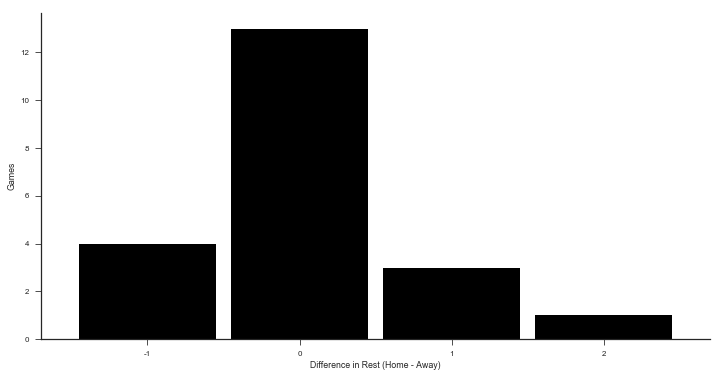

In [12]:
#We now plot a bar graph of the above data using seaborn library
# we store rest_spread in variable delta.
delta = (by_game.home_rest - by_game.away_rest).dropna().astype(int)
ax = (delta.value_counts() # counts the number of similar set of values
    .reindex(np.arange(delta.min(), delta.max() + 1), fill_value=0) # Reindex the data and sort index before plotting
    .sort_index()
    .plot(kind='bar', color='k', width=.9, rot=0, figsize=(12, 6)) # Details about Which type of graph to plot
)
sns.despine() #Remove the top and right spines (square edges) from plot
ax.set(xlabel='Difference in Rest (Home - Away)', ylabel='Games'); # we name the x axis and y axis

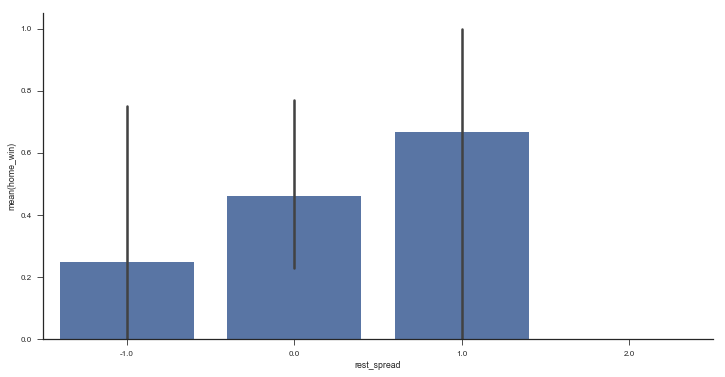

In [13]:
#We calculate the win percent by rest difference and plot it

fig, ax = plt.subplots(figsize=(12, 6))
sns.barplot(x='rest_spread', y='home_win', data=df.query('-3 <= rest_spread <= 3'), # name x and y axis and plot data in range -3 to 3
            color='#4c72b0', ax=ax)
sns.despine()

In [14]:
# Pandas has two useful methods for quickly converting from wide to long format (stack) and long to wide (unstack).
# rest is in a "long" form since we have a single column of data, with multiple "columns" of metadata (in the MultiIndex). 
# We use .unstack to move from long to wide.

rest = (tidy.groupby(['date', 'variable'])
            .rest.mean()
            .dropna())
rest.head()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
Name: rest, dtype: float64

In [15]:
rest.unstack().head()

variable,away_team,home_team
date,,
2015-10-28,0.000000,0.000000
2015-10-29,0.333333,0.000000
2015-10-30,1.083333,0.916667
2015-10-31,0.166667,0.833333


In [16]:
#unstack moves a level of a MultiIndex (innermost by default) up to the columns. stack is the inverse.
rest.unstack().stack()

date        variable 
2015-10-28  away_team    0.000000
            home_team    0.000000
2015-10-29  away_team    0.333333
            home_team    0.000000
2015-10-30  away_team    1.083333
            home_team    0.916667
2015-10-31  away_team    0.166667
            home_team    0.833333
dtype: float64

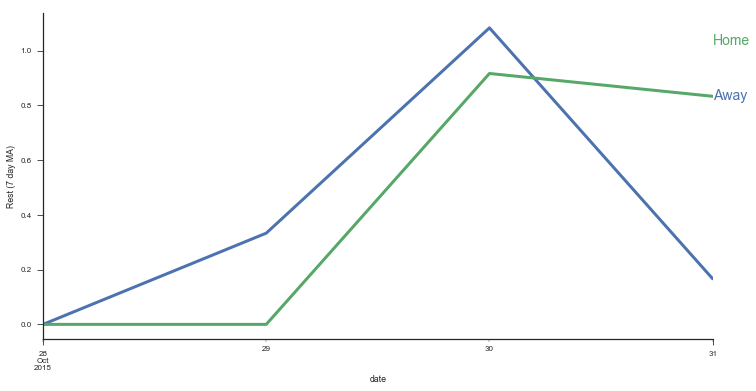

In [21]:
# With .unstack you can move between those APIs that expect there data in long-format and those APIs 
# that work with wide-format data. 

with sns.color_palette() as pal:
    b, g = pal.as_hex()[:2]

ax=(rest.unstack()
        .query('away_team < 7')
         #.rolling(7)
         #.mean()
        .plot(figsize=(12, 6), linewidth=3, legend=False))
ax.set(ylabel='Rest (7 day MA)') # y axis name set

# We sometimes annotate some feature of the plot, and the annotate() method provides helper functionality to make annotations easy. 
# In an annotation, there are two points to consider: the location being annotated represented by the argument xy and the location of the text xytext. 
# Both of these arguments are (x,y) tuples.

ax.annotate("Home", (rest.index[-1][0], 1.02), color=g, size=14) 
ax.annotate("Away", (rest.index[-1][0], 0.82), color=b, size=14)
sns.despine()                 

References:
https://tomaugspurger.github.io/modern-5-tidy.html
https://seaborn.pydata.org/
https://pandas.pydata.org/pandas-docs/